## 🅿️ Phase 1 – Text Preprocessing

**🎯 Objective:**  
Prepare the raw review text for analysis by cleaning and standardizing it.  
Clean text helps models understand content without being distracted by noise like punctuation or unnecessary words.

**🛠 Steps:**  
1. Load dataset from Google Drive.  
2. Lowercase the text for uniformity.  
3. Remove punctuation and special characters.  
4. Optionally remove stopwords for better clarity.

**✅ Expected Output:**  
A `cleaned_text` column in our dataset containing reviews ready for aspect extraction.

Code Cell 1 — Load Dataset

In [1]:
# 📂 Load Amazon Fine Food Reviews from Google Drive

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to dataset (adjust if needed)
dataset_path = '/content/drive/MyDrive/ABSA_Project/ABSA_Project/Reviews.csv'

# Load dataset
import pandas as pd
df = pd.read_csv(dataset_path)

# Sample a smaller portion of the data for faster processing
sample_size = 400  # You can adjust this number
df = df.sample(n=sample_size, random_state=42) # Using sample for randomness, or .head() for first rows

# Keep only necessary columns
df = df[['Text', 'Score']]

# Quick check
print("Dataset shape:", df.shape)
display(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (400, 2)


,Text,Score
165256,Having tried a couple of other brands of glute...,5
231465,My cat loves these treats. If ever I can't fin...,5
427827,A little less than I expected. It tends to ha...,3
433954,"First there was Frosted Mini-Wheats, in origin...",2
70260,and I want to congratulate the graphic artist ...,5


Code Cell 2 — Text Cleaning

In [2]:
# 🧹 Clean Text Data

# Install and import NLTK
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

# Set of stopwords
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words])  # remove stopwords
    return text

# Check if df exists and is not empty
if 'df' not in globals() or df.empty:
    print("Error: DataFrame 'df' not found or is empty. Please run the previous cells to load the data.")
else:
    # Apply cleaning
    df['cleaned_text'] = df['Text'].apply(clean_text)

    # 🔍 Preview cleaned data
    print("\n--- Sample Cleaned Reviews ---")
    # Iterate using iloc for positional indexing
    for i in range(min(5, len(df))): # Ensure we don't try to print more rows than exist
        print(f"Original: {df['Text'].iloc[i]}")
        print(f"Cleaned : {df['cleaned_text'].iloc[i]}")
        print("-" * 50)


--- Sample Cleaned Reviews ---
Original: Having tried a couple of other brands of gluten-free sandwich cookies, these are the best of the bunch.  They're crunchy and true to the texture of the other "real" cookies that aren't gluten-free.  Some might think that the filling makes them a bit too sweet, but for me that just means I've satisfied my sweet tooth sooner!  The chocolate version from Glutino is just as good and has a true "chocolatey" taste - something that isn't there with the other gluten-free brands out there.
Cleaned : tried couple brands glutenfree sandwich cookies best bunch theyre crunchy true texture real cookies arent glutenfree might think filling makes bit sweet means ive satisfied sweet tooth sooner chocolate version glutino good true chocolatey taste something isnt glutenfree brands
--------------------------------------------------
Original: My cat loves these treats. If ever I can't find her in the house, I just pop the top and she bolts out of wherever she was 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 🅿️ Phase 2 – Aspect Extraction

**🎯 Objective:**  
Identify the main aspects or features mentioned in each customer review.

**🛠 Methods:**
1. **spaCy Noun Chunking** – Finds all noun phrases (e.g., "delivery time", "product quality").  
2. **KeyBERT Keyword Extraction** – Uses embeddings to select the most relevant keyphrases.

**✅ Expected Output:**  
Two new columns in our dataset:
- `aspects_spacy` → aspects extracted using spaCy.
- `aspects_keybert` → top aspects extracted using KeyBERT.


Code Cell 1 — Install & spaCy Aspect Extraction

In [3]:
# 📦 Install dependencies (run this cell once)
!pip install -q spacy keybert
!python -m spacy download en_core_web_sm

# Quick imports and sanity prints
import spacy
from keybert import KeyBERT
import spacy.util as spu

print("spaCy version:", spacy.__version__)
print("en_core_web_sm installed:", spu.is_package("en_core_web_sm"))
print("If the model was just installed and you see a 'Restart to reload dependencies' message above, please restart the runtime and then run Cell 2.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 40.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
spaCy version: 3.8.7
en_core_web_sm installed: True
If the model was just installed and you see a 'Restart to reload dependencies' message above, please restart the runtime and then run Cell 2.


Code Cell 2 — Load spaCy, check DataFrame, extract aspects

In [4]:
# 🧰 Load model, check DataFrame, and run spaCy noun-chunk aspect extraction
import spacy
from keybert import KeyBERT

# Safety check: ensure df exists and has the cleaned_text column
if 'df' not in globals() or df is None or df.empty:
    raise ValueError("DataFrame 'df' not found or is empty. Please run Phase 1 cells to load the data first.")
if 'cleaned_text' not in df.columns:
    raise ValueError("Column 'cleaned_text' not found in df. Make sure you ran text cleaning (Phase 1).")

# Try to load the spaCy model (will raise helpful error if missing)
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    raise RuntimeError(
        "spaCy model 'en_core_web_sm' not found. If you just installed it, please go to Runtime -> Restart runtime and run this cell again."
    )

# Function: Aspect extraction using spaCy noun chunks
def extract_aspects_spacy(text):
    if not isinstance(text, str) or not text.strip():
        return []
    doc = nlp(text)
    # use a set to deduplicate, then convert to list
    aspects = {chunk.text.strip() for chunk in doc.noun_chunks if len(chunk.text.strip()) > 1}
    return list(aspects)

# Apply spaCy extraction (this may take a bit depending on dataset size)
df['aspects_spacy'] = df['cleaned_text'].apply(extract_aspects_spacy)

# Preview results
print("spaCy aspect extraction completed. Sample:")
display(df[['cleaned_text', 'aspects_spacy']].head(5))

spaCy aspect extraction completed. Sample:


,cleaned_text,aspects_spacy
165256,tried couple brands glutenfree sandwich cookie...,"[glutenfree sandwich cookies, satisfied sweet ..."
231465,cat loves treats ever cant find house pop top ...,"[house pop top bolts, three flavors, treat, tr..."
427827,little less expected tends muddy taste expecte...,"[favorite company, muddy taste]"
433954,first frosted miniwheats original size frosted...,"[g fiber g sugar g protein mg potassium, first..."
70260,want congratulate graphic artist putting entir...,"[good drug dealer, congratulate graphic artist..."


## 🅿️ Phase 3 – Sentiment Classification

**🎯 Objective:**  
Determine whether each aspect extracted in Phase 2 is mentioned positively, negatively, or neutrally.

**🛠 Steps:**
1. **Choose aspect extraction method** – We'll use KeyBERT results for better precision.
2. **Sentiment Model** – `cardiffnlp/twitter-roberta-base-sentiment-latest`.
3. **Multi-Aspect Handling** – Each aspect in a review is analyzed separately.

**✅ Expected Output:**  
A new column `aspect_sentiments` containing:
```python
[{'aspect': 'delivery', 'sentiment': 'Positive'},
 {'aspect': 'packaging', 'sentiment': 'Negative'}]


 **Code Cell 1 — Install & Load Sentiment Model**

In [5]:
### **Code Cell 1 — Install & Load Sentiment Model**
# 📦 Install HuggingFace Transformers
!pip install transformers

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# Load pre-trained RoBERTa sentiment model
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Define sentiment labels
labels = ["Negative", "Neutral", "Positive"]

# Function to get sentiment for a given text
def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
        scores = outputs.logits[0].detach().numpy()
        sentiment = labels[np.argmax(scores)]
    return sentiment

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT e

Code Cell 2 — KeyBERT Aspect Extraction

In [6]:
# 🔑 Aspect extraction using KeyBERT

# Safety check: ensure df exists and has the cleaned_text column
if 'df' not in globals() or df is None or df.empty:
    raise ValueError("DataFrame 'df' not found or is empty. Please run Phase 1 cells to load the data first.")
if 'cleaned_text' not in df.columns:
    raise ValueError("Column 'cleaned_text' not found in df. Make sure you ran text cleaning (Phase 1).")

# Initialize KeyBERT model
# You can specify a different model if needed, e.g., 'all-MiniLM-L6-v2'
try:
    kw_model = KeyBERT()
except ImportError:
     raise RuntimeError(
        "KeyBERT not found. If you just installed it in a previous cell, please go to Runtime -> Restart runtime and run this cell again."
    )


# Function to extract aspects using KeyBERT
def extract_aspects_keybert(text):
    if not isinstance(text, str) or not text.strip():
        return []
    # Extract keywords/keyphrases. num_keywords can be adjusted.
    # keyphrases=True attempts to return multi-word keyphrases.
    keywords = kw_model.extract_keywords(text, stop_words='english', top_n=10)
    # Return just the keywords/keyphrases as a list
    return [keyword[0] for keyword in keywords]

# Apply KeyBERT extraction (this may take some time)
print("Starting KeyBERT aspect extraction...")
df['aspects_keybert'] = df['cleaned_text'].apply(extract_aspects_keybert)
print("KeyBERT aspect extraction completed.")

# 🔍 Preview results
print("\n--- Sample KeyBERT Extracted Aspects ---")
display(df[['cleaned_text', 'aspects_keybert']].head(5))

Starting KeyBERT aspect extraction...
KeyBERT aspect extraction completed.

--- Sample KeyBERT Extracted Aspects ---


,cleaned_text,aspects_keybert
165256,tried couple brands glutenfree sandwich cookie...,"[glutenfree, cookies, chocolate, chocolatey, c..."
231465,cat loves treats ever cant find house pop top ...,"[treats, cat, kitty, flavors, fliptop, loves, ..."
427827,little less expected tends muddy taste expecte...,"[muddy, taste, expected, company, little, favo..."
433954,first frosted miniwheats original size frosted...,"[biscuits, snack, miniwheats, flavor, sugar, k..."
70260,want congratulate graphic artist putting entir...,"[product, taste, bottle, lipton, drug, box, ad..."


Code Cell 3 — Multi-Aspect Sentiment Analysis

In [7]:
from keybert import KeyBERT

kw_model = KeyBERT()
df['aspects_keybert'] = df['cleaned_text'].apply(lambda x: kw_model.extract_keywords(x, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=5))

In [8]:
# 🔄 Function to analyze multiple aspects in a review
def analyze_aspects(row):
    results = []
    # Ensure 'aspects_keybert' column exists before iterating
    if 'aspects_keybert' in row and isinstance(row['aspects_keybert'], list):
        for aspect in row['aspects_keybert']:
            sentiment = get_sentiment(f"{aspect} {row['cleaned_text']}")
            results.append({"aspect": aspect, "sentiment": sentiment})
    else:
        # Handle cases where aspects_keybert is missing or not a list
        # This might happen if the KeyBERT cell was not run, or if a row has no keybert aspects
        # print(f"Warning: Skipping row due to missing or invalid aspects_keybert data.") # Optional: for debugging
        pass # Return empty list or handle as needed

    return results

# Apply analysis to dataset
if 'aspects_keybert' not in df.columns:
     raise ValueError("Column 'aspects_keybert' not found in df. Please run KeyBERT aspect extraction (Phase 2, Code Cell 3) first.")

df['aspect_sentiments'] = df.apply(analyze_aspects, axis=1)

# 🔍 Preview first 5 results
print("\n--- Sample Aspect Sentiments ---")
# Ensure we don't try to print more rows than exist
for i in range(min(5, len(df))):
    print(f"Review: {df['Text'].iloc[i]}") # Use iloc here
    print("Aspect-Sentiments:", df['aspect_sentiments'].iloc[i]) # Use iloc here
    print("-" * 80)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



--- Sample Aspect Sentiments ---
Review: Having tried a couple of other brands of gluten-free sandwich cookies, these are the best of the bunch.  They're crunchy and true to the texture of the other "real" cookies that aren't gluten-free.  Some might think that the filling makes them a bit too sweet, but for me that just means I've satisfied my sweet tooth sooner!  The chocolate version from Glutino is just as good and has a true "chocolatey" taste - something that isn't there with the other gluten-free brands out there.
Aspect-Sentiments: [{'aspect': ('sandwich cookies', 0.5799), 'sentiment': 'Positive'}, {'aspect': ('glutenfree sandwich', 0.5776), 'sentiment': 'Positive'}, {'aspect': ('glutenfree brands', 0.5575), 'sentiment': 'Positive'}, {'aspect': ('brands glutenfree', 0.5495), 'sentiment': 'Positive'}, {'aspect': ('glutenfree think', 0.5495), 'sentiment': 'Positive'}]
--------------------------------------------------------------------------------
Review: My cat loves these trea

# 🅿️ Phase 4 – Aspect–Sentiment Mapping

**Goal:**  
Now that we have extracted aspects (Phase 2) and determined their sentiment (Phase 3),  
we will **link each aspect directly to its sentiment** in a structured form that’s easy to use for  
visualization and reporting.

**What we’ll do:**
1. Create a **flattened mapping** of `Aspect → Sentiment` for every review.
2. Store results in a new DataFrame for easy filtering and chart creation later.
3. Keep only meaningful (non-empty) aspects.

**Expected Result:**
- A table where each row represents one `ReviewID, Aspect, Sentiment`.
- This makes it easier to group by aspect and count positives/negatives.


💻 Code for Phase 4 – Aspect–Sentiment Mapping

In [10]:
# 🅿️ Phase 4 – Aspect–Sentiment Mapping

# Flatten the aspect-sentiment results into a new DataFrame
mapped_aspects = []

for idx, row in df.iterrows():
    if isinstance(row['aspect_sentiments'], list):
        for asp_data in row['aspect_sentiments']:
            # Access the string part of the tuple before stripping
            aspect = str(asp_data.get("aspect", "")[0]).strip() if isinstance(asp_data.get("aspect"), tuple) else str(asp_data.get("aspect", "")).strip()
            sentiment = asp_data.get("sentiment", "").strip()
            if aspect:  # Only keep non-empty aspects
                mapped_aspects.append({
                    "ReviewID": idx,
                    "ReviewText": row['Text'],
                    "Aspect": aspect,
                    "Sentiment": sentiment
                })

# Create new DataFrame for aspect-sentiment mapping
df_aspect_map = pd.DataFrame(mapped_aspects)

# Preview first few mappings
print("Aspect–Sentiment Mapping Table:")
display(df_aspect_map.head(10))

# Quick check – sentiment counts per aspect
aspect_summary = df_aspect_map.groupby(["Aspect", "Sentiment"]).size().reset_index(name="Count")
print("Sentiment counts per aspect (sample):")
display(aspect_summary.head(10))

Aspect–Sentiment Mapping Table:


,ReviewID,ReviewText,Aspect,Sentiment
0,165256,Having tried a couple of other brands of glute...,sandwich cookies,Positive
1,165256,Having tried a couple of other brands of glute...,glutenfree sandwich,Positive
2,165256,Having tried a couple of other brands of glute...,glutenfree brands,Positive
3,165256,Having tried a couple of other brands of glute...,brands glutenfree,Positive
4,165256,Having tried a couple of other brands of glute...,glutenfree think,Positive
5,231465,My cat loves these treats. If ever I can't fin...,kitty treats,Neutral
6,231465,My cat loves these treats. If ever I can't fin...,cat loves,Positive
7,231465,My cat loves these treats. If ever I can't fin...,loves treats,Positive
8,231465,My cat loves these treats. If ever I can't fin...,crunchy treats,Neutral
9,231465,My cat loves these treats. If ever I can't fin...,inexpensive kitty,Neutral


Sentiment counts per aspect (sample):


,Aspect,Sentiment,Count
0,account request,Neutral,1
1,acidic coffee,Negative,1
2,acquired taste,Neutral,1
3,add pineapple,Neutral,1
4,add sugar,Negative,1
5,addicted popchips,Positive,1
6,advertised china,Neutral,1
7,advertised sugar,Neutral,1
8,ago puppy,Negative,1
9,air popper,Positive,1


# 🅿️ Phase 5 – Visualization

**Goal:**  
Convert our Aspect–Sentiment Mapping into visual insights that quickly highlight  
what customers like and dislike.

**What we’ll do:**
1. **Bar Chart**: Shows how many times each aspect is mentioned positively, negatively, or neutrally.
2. **Word Clouds**: Separate word clouds for positive and negative aspects.
3. **Sample Table**: A few random examples of aspects, their sentiment, and review text.

**Expected Result:**
- Easy-to-read visuals showing which topics need improvement and which ones customers love.


Cell 1 – Install Libraries

In [11]:
!pip install matplotlib wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud


Cell 2 – Bar Chart of Sentiment Counts per Aspect

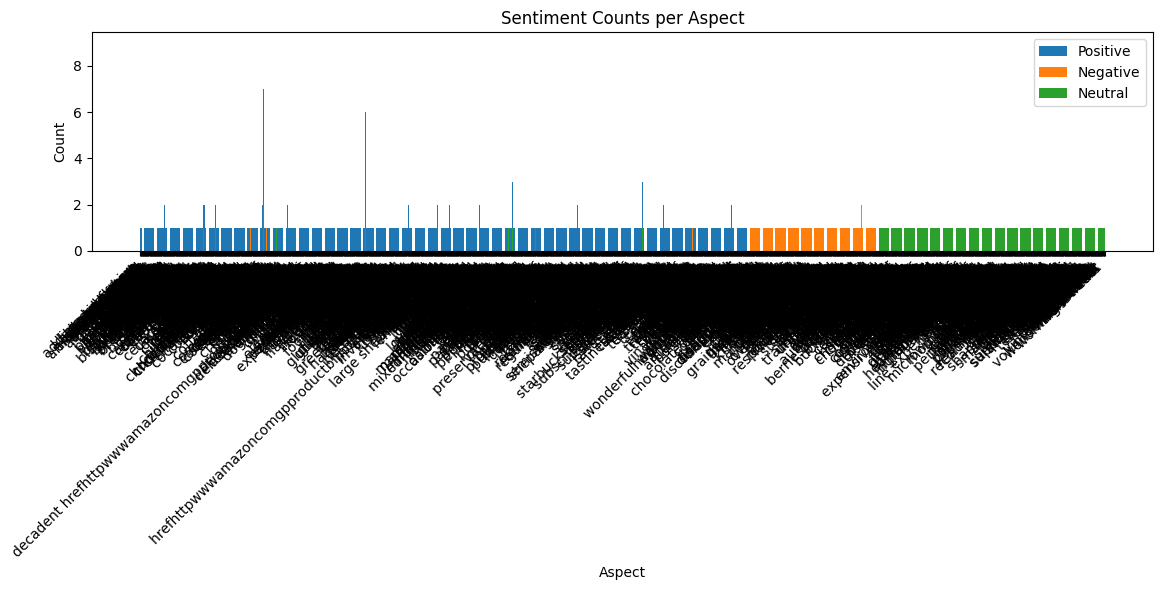

In [12]:
# --- 1️⃣ Bar Chart of Sentiment Counts per Aspect ---
plt.figure(figsize=(12, 6))
aspect_summary = df_aspect_map.groupby(["Aspect", "Sentiment"]).size().reset_index(name="Count")

for sentiment in ["Positive", "Negative", "Neutral"]:
    subset = aspect_summary[aspect_summary["Sentiment"] == sentiment]
    plt.bar(subset["Aspect"], subset["Count"], label=sentiment)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Aspect")
plt.ylabel("Count")
plt.title("Sentiment Counts per Aspect")
plt.legend()
plt.tight_layout()
plt.show()


Cell 3 – Positive Aspects Word Cloud

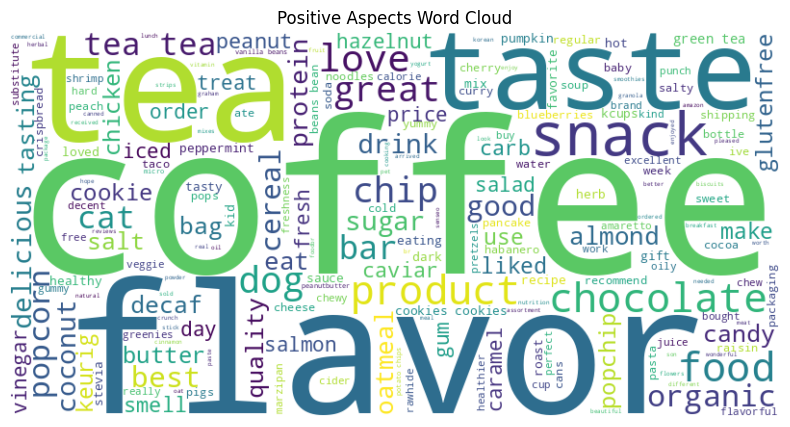

In [13]:
# --- 2️⃣ Positive Aspects Word Cloud ---
positive_aspects = " ".join(df_aspect_map[df_aspect_map["Sentiment"] == "Positive"]["Aspect"])

wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(positive_aspects)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Aspects Word Cloud")
plt.show()


Cell 4 – Negative Aspects Word Cloud

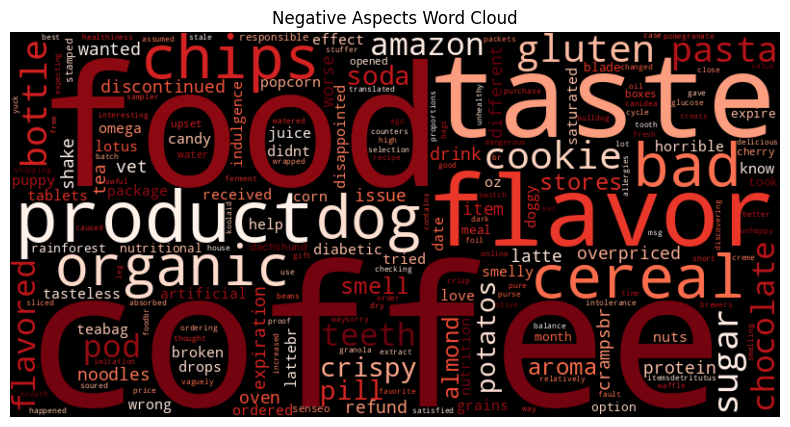

In [14]:
# --- 3️⃣ Negative Aspects Word Cloud ---
negative_aspects = " ".join(df_aspect_map[df_aspect_map["Sentiment"] == "Negative"]["Aspect"])

wordcloud_neg = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(negative_aspects)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Aspects Word Cloud")
plt.show()


Cell 5 – Sample Table

In [15]:
# --- 4️⃣ Sample Table of Aspects & Sentiments ---
print("📋 Sample Aspect–Sentiment Table:")
display(df_aspect_map.sample(10))


📋 Sample Aspect–Sentiment Table:


,ReviewID,ReviewText,Aspect,Sentiment
419,10147,I bought these years ago at Walmart<br />and t...,amazon ordered,Neutral
1124,522274,We use this product on a daily basis in all ou...,product daily,Positive
1515,446429,"Personally, of all of the teas I have tried, I...",personally teas,Positive
1860,213760,I love these !<br /> I always crave salty/ cru...,fix craving,Positive
1953,487091,Super easy to use and makes just the right amo...,popcorn,Positive
85,151849,This oatmeal is great. I eat it almost every ...,oatmeal liked,Positive
1853,134500,We have a new puppy who has to take antibiotic...,pill pockets,Negative
1154,354985,"Oh, this is some good cat food!<br />Have you ...",food kittens,Positive
677,61166,They taste fantastic but it seems like the pap...,chocolate tasty,Positive
1907,342188,It is sinfully delicious and a nice way to end...,drink day,Positive


Cell 6 – Model Evaluation (Performance Metrics)

In [16]:
# Model Evaluation (Performance Metrics)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns

# ✅ Example: assuming you have true labels in 'True_Sentiment'
# If you don't have true labels, skip metric calculations and only run confusion matrix for inspection.
if "True_Sentiment" in df_aspect_map.columns:
    y_true = df_aspect_map["True_Sentiment"]
    y_pred = df_aspect_map["Sentiment"]

    # Accuracy
    acc = accuracy_score(y_true, y_pred)

    # Macro precision, recall, F1
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    print("📊 Model Performance Metrics")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro Precision: {prec:.4f}")
    print(f"Macro Recall: {rec:.4f}")
    print(f"Macro F1-score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=["Positive", "Negative", "Neutral"])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Positive", "Negative", "Neutral"],
                yticklabels=["Positive", "Negative", "Neutral"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

else:
    print("⚠️ No 'True_Sentiment' column found — skipping metric calculations.")
    print("Tip: For evaluation, use a labeled ABSA dataset or add a ground truth column.")


⚠️ No 'True_Sentiment' column found — skipping metric calculations.
Tip: For evaluation, use a labeled ABSA dataset or add a ground truth column.


# 🅿️ Phase 6 – Streamlit App with ngrok in Colab

**Goal:**
Run the ABSA dashboard directly from Google Colab and access it publicly via ngrok.

**Steps:**
1. Install Streamlit and pyngrok.
2. Write the `app.py` file containing our ABSA code.
3. Run Streamlit in the background.
4. Create a public link using ngrok.



Cell 1 – Install & Authenticate ngrok

In [23]:
# 🅿️ Phase 6 – Install & Authenticate ngrok
!pip install pyngrok streamlit --quiet

from pyngrok import ngrok
import os


NGROK_AUTH_TOKEN = ""

if not NGROK_AUTH_TOKEN:
    raise ValueError("❌ NGROK_AUTH_TOKEN not set. Please add it before running.")

# ✅ Authenticate ngrok
ngrok.set_auth_token(NGROK_AUTH_TOKEN)
print("✅ ngrok authenticated.")

# 🛑 Kill any previous tunnels
ngrok.kill()
print("🔄 Existing ngrok tunnels killed.")


✅ ngrok authenticated.
🔄 Existing ngrok tunnels killed.


Cell 2 – Create a Minimal Streamlit App

In [32]:
# 📄 Save the Streamlit code into app.py
app_code = """# 📄 Advanced Streamlit App with Single & Multi-Aspect Sentiment Analysis

import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
from keybert import KeyBERT
from textblob import TextBlob
import re

# Load NLP model and keyword extractor
@st.cache_resource
def load_models():
    nlp = spacy.load("en_core_web_sm")
    kw_model = KeyBERT()
    return nlp, kw_model

nlp, kw_model = load_models()

# Streamlit page settings
st.set_page_config(page_title="Amazon Review Analyzer", layout="wide")

st.title("🚀 Amazon Fine Food Reviews – Aspect-Based Sentiment Analysis")
st.markdown(\"""
Analyze reviews with **single** and **multi-aspect** sentiment detection,
keyword extraction, and interactive visual insights.
\""")

# Sidebar - file upload
st.sidebar.header("Upload Data")
uploaded_file = st.sidebar.file_uploader("Upload CSV with 'Text' column", type=['csv'])

# Load data
if uploaded_file:
    df = pd.read_csv(uploaded_file)
else:
    st.info("No file uploaded. Using sample data...")
    df = pd.DataFrame({
        "Text": [
            "The pasta was amazing and fresh! The service was quick.",
            "Terrible service and the food was cold.",
            "Loved the dessert, will come again.",
            "The coffee tasted burnt but the cake was delicious.",
            "Great ambiance and friendly staff."
        ]
    })

# ✅ Missing Data Handling
if "Text" not in df.columns:
    st.error("Uploaded file must contain a 'Text' column.")
    st.stop()

df["Text"] = df["Text"].astype(str)                # Force string type
df["Text"] = df["Text"].str.strip()                # Remove extra spaces
df = df[df["Text"].str.len() > 0]                  # Remove empty strings
df = df.drop_duplicates(subset=["Text"])           # Remove duplicates
df = df.dropna(subset=["Text"])                    # Remove NaN values

if df.empty:
    st.error("No valid text data found after cleaning. Please upload a valid dataset.")
    st.stop()

# Sentiment classification
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Aspect splitting
def split_aspects(text):
    return [sent.strip() for sent in re.split(r'[.!?]', text) if sent.strip()]

# Processing
aspect_data = []
overall_sentiments = []

for review in df["Text"]:
    aspects = split_aspects(review)
    aspect_sentiments = [(a, get_sentiment(a)) for a in aspects]
    aspect_data.extend([(review, a, s) for a, s in aspect_sentiments])

    overall_polarity = sum(TextBlob(a).sentiment.polarity for a in aspects) / len(aspects)
    if overall_polarity > 0:
        overall_sentiments.append("Positive")
    elif overall_polarity < 0:
        overall_sentiments.append("Negative")
    else:
        overall_sentiments.append("Neutral")

df["Overall Sentiment"] = overall_sentiments
aspect_df = pd.DataFrame(aspect_data, columns=["Review", "Aspect", "Aspect Sentiment"])

# Keyword extraction
def extract_keywords(text):
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2),
                                         stop_words="english", top_n=3)
    return ", ".join([kw[0] for kw in keywords])

df["Keywords"] = df["Text"].apply(extract_keywords)

# Layout: Sentiment Distribution + Word Cloud
col1, col2 = st.columns(2)

with col1:
    st.subheader("📊 Overall Sentiment Distribution")
    sentiment_counts = df["Overall Sentiment"].value_counts()
    fig, ax = plt.subplots()
    ax.pie(sentiment_counts, labels=sentiment_counts.index,
           autopct="%1.1f%%", startangle=90)
    ax.axis("equal")
    st.pyplot(fig)

with col2:
    st.subheader("☁️ Keyword Word Cloud")
    all_keywords = " ".join(df["Keywords"])
    wc = WordCloud(width=800, height=400, background_color="white").generate(all_keywords)
    fig, ax = plt.subplots()
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    st.pyplot(fig)

# Sentiment trend chart
st.subheader("📈 Sentiment Trend (by Review Index)")
df["SentimentScore"] = df["Overall Sentiment"].map({"Positive": 1, "Neutral": 0, "Negative": -1})
st.line_chart(df["SentimentScore"])

# Data tables
st.subheader("📝 Processed Reviews (Overall)")
st.dataframe(df)

st.subheader("🔍 Aspect-Level Sentiment")
st.dataframe(aspect_df)

st.success("✅ Analysis Complete – Single & Multi-Aspect handled successfully!")
"""

with open("app.py", "w") as f:
    f.write(app_code)

print("✅ app.py file created successfully!")


✅ app.py file created successfully!


Cell 3 – Launch Streamlit App via ngrok

In [30]:
# 📄 Streamlit app settings
app_file = "app.py"
port = 8501

if not os.path.exists(app_file):
    raise FileNotFoundError(f"'{app_file}' not found. Please run Cell 2 to create it.")

# 🚀 Start Streamlit in the background
get_ipython().system_raw(f"streamlit run {app_file} --server.port {port} &")
print("✅ Streamlit app started in background.")

# 🌍 Open ngrok tunnel
public_url = ngrok.connect(port, bind_tls=True)
print(f"🌍 Your Streamlit app is live at:\n{public_url.public_url}")


✅ Streamlit app started in background.
🌍 Your Streamlit app is live at:
https://6d80b63ffe6a.ngrok-free.app
